In [1]:
# ========== CELL 1: Enhanced Imports ==========
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import os
import zipfile
import random
from PIL import Image
import cv2
import pandas as pd
from collections import Counter
import json

print("All libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")

All libraries imported successfully!
TensorFlow version: 2.19.0


In [2]:
# Download the dataset from Kaggle
!pip install kaggle

# Upload your kaggle.json file when prompted
from google.colab import files
files.upload()  # Upload your kaggle.json file here

# Create kaggle directory and set permissions
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
# !kaggle datasets download -d vbookshelf/rice-leaf-diseases
!kaggle datasets download -d smaranjitghose/corn-or-maize-leaf-disease-dataset

# Extract the dataset
with zipfile.ZipFile('corn-or-maize-leaf-disease-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/corn-leaf-diseases')

print("Dataset downloaded and extracted successfully!")

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/smaranjitghose/corn-or-maize-leaf-disease-dataset
License(s): copyright-authors
 94% 151M/161M [00:00<00:00, 1.57GB/s]
100% 161M/161M [00:00<00:00, 1.54GB/s]
Dataset downloaded and extracted successfully!


📁 Analyzing dataset at: /content/corn-leaf-diseases/data


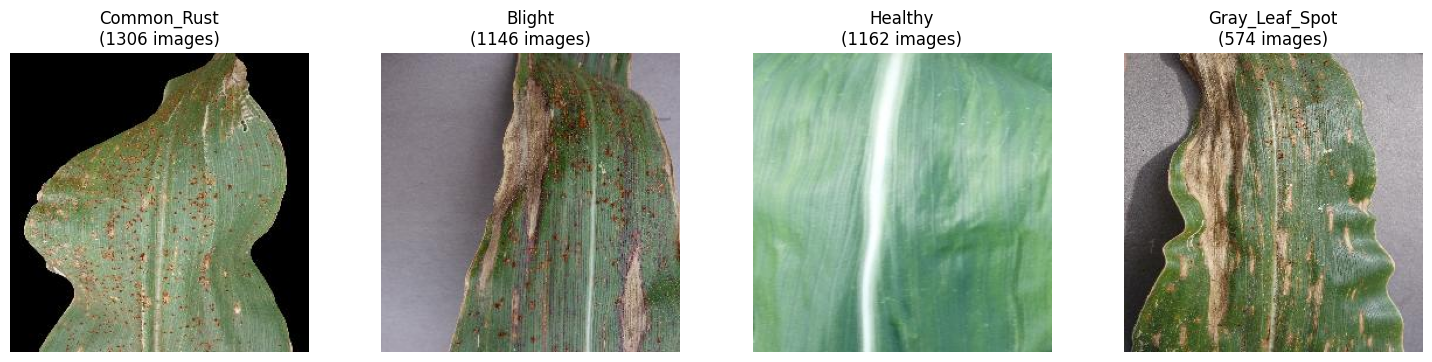


📊 DATASET ANALYSIS REPORT:
Total classes: 4
Total images: 4188
Average images per class: 1047.0

Class Distribution:
  Common_Rust: 1306 images (31.2%)
  Healthy: 1162 images (27.7%)
  Blight: 1146 images (27.4%)
  Gray_Leaf_Spot: 574 images (13.7%)

Average image size: 268x263


In [3]:
# ========== CELL 3: Enhanced Dataset Analysis ==========
def analyze_dataset(dataset_path):
    """Comprehensive dataset analysis with visualization"""

    # Find the actual data directory
    actual_data_path = dataset_path
    for root, dirs, files in os.walk(dataset_path):
        if 'data' in dirs:
            actual_data_path = os.path.join(root, 'data')
            break
        elif any(fname.lower().endswith(('.jpg', '.jpeg', '.png')) for fname in files):
            actual_data_path = root
            break

    print(f"📁 Analyzing dataset at: {actual_data_path}")

    # Get classes (subdirectories)
    classes = [d for d in os.listdir(actual_data_path)
               if os.path.isdir(os.path.join(actual_data_path, d))]

    class_info = {}
    image_info = {
        'sizes': [],
        'formats': [],
        'total_images': 0
    }

    plt.figure(figsize=(15, 10))

    for i, class_name in enumerate(classes):
        class_path = os.path.join(actual_data_path, class_name)
        images = [f for f in os.listdir(class_path)
                 if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        class_info[class_name] = len(images)
        image_info['total_images'] += len(images)

        # Analyze sample images
        for img_file in images[:5]:  # Sample first 5 images
            img_path = os.path.join(class_path, img_file)
            try:
                with Image.open(img_path) as img:
                    image_info['sizes'].append(img.size)
                    image_info['formats'].append(img.format)
            except Exception as e:
                print(f"Warning: Could not open {img_path}: {e}")

        # Plot sample images
        if images:
            sample_img = random.choice(images)
            img_path = os.path.join(class_path, sample_img)
            try:
                plt.subplot(3, 4, i+1)
                img = Image.open(img_path)
                plt.imshow(img)
                plt.title(f'{class_name}\n({len(images)} images)')
                plt.axis('off')
            except Exception as e:
                print(f"Could not display image {img_path}: {e}")

    plt.tight_layout()
    plt.show()

    # Print analysis results
    print("\n📊 DATASET ANALYSIS REPORT:")
    print("="*50)
    print(f"Total classes: {len(classes)}")
    print(f"Total images: {image_info['total_images']}")
    print(f"Average images per class: {image_info['total_images']/len(classes):.1f}")

    print("\nClass Distribution:")
    for class_name, count in sorted(class_info.items(), key=lambda x: x[1], reverse=True):
        percentage = (count / image_info['total_images']) * 100
        print(f"  {class_name}: {count} images ({percentage:.1f}%)")

    # Size analysis
    if image_info['sizes']:
        avg_width = np.mean([size[0] for size in image_info['sizes']])
        avg_height = np.mean([size[1] for size in image_info['sizes']])
        print(f"\nAverage image size: {avg_width:.0f}x{avg_height:.0f}")

    return actual_data_path, class_info

# Run analysis
dataset_path, class_info = analyze_dataset('/content/corn-leaf-diseases')

In [4]:
# ========== CELL 4: Advanced Data Cleaning ==========
def advanced_clean_dataset(dataset_path):
    """Enhanced cleaning with better error handling and reporting"""

    corrupted_count = 0
    valid_images = 0
    size_stats = []

    print("🧹 Cleaning dataset...")

    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)
        if not os.path.isdir(class_path):
            continue

        for img_file in os.listdir(class_path):
            if not img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue

            img_path = os.path.join(class_path, img_file)

            try:
                # Try to open and verify image
                with Image.open(img_path) as img:
                    img.verify()

                # Check if image can be loaded and converted to array
                img = Image.open(img_path)
                img_array = np.array(img)

                # Check image dimensions
                if img_array.size == 0:
                    raise ValueError("Empty image")

                # Check for minimum size
                if min(img_array.shape[:2]) < 50:
                    print(f"Removing too small image: {img_path}")
                    os.remove(img_path)
                    corrupted_count += 1
                    continue

                valid_images += 1
                size_stats.append(img_array.shape[:2])

            except Exception as e:
                print(f"Removing corrupted image: {img_path} - Error: {str(e)[:50]}...")
                try:
                    os.remove(img_path)
                    corrupted_count += 1
                except:
                    pass

    print(f"✅ Cleaning completed!")
    print(f"Removed {corrupted_count} corrupted images")
    print(f"Valid images remaining: {valid_images}")

    if size_stats:
        avg_height = np.mean([h for h, w in size_stats])
        avg_width = np.mean([w for h, w in size_stats])
        print(f"Average image size: {avg_height:.0f}x{avg_width:.0f}")

    return valid_images

valid_count = advanced_clean_dataset(dataset_path)

🧹 Cleaning dataset...
✅ Cleaning completed!
Removed 0 corrupted images
Valid images remaining: 4188
Average image size: 298x308


In [5]:
# ========== CELL 5: Enhanced Data Generators ==========
# Parameters
IMG_SIZE = (384, 384)  # Increased size for better feature extraction
BATCH_SIZE = 32
EPOCHS = 50
VALIDATION_SPLIT = 0.2
RANDOM_SEED = 42

# Enhanced Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=False,  # Usually not needed for leaves
    brightness_range=[0.8, 1.2],
    channel_shift_range=0.1,
    fill_mode='reflect',
    validation_split=VALIDATION_SPLIT
)

val_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    validation_split=VALIDATION_SPLIT
)

# Create data generators
try:
    train_generator = train_datagen.flow_from_directory(
        dataset_path,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='training',
        shuffle=True,
        seed=RANDOM_SEED
    )

    val_generator = val_datagen.flow_from_directory(
        dataset_path,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='validation',
        shuffle=False,
        seed=RANDOM_SEED
    )

    # Calculate class weights for handling imbalance
    class_weights = compute_class_weight(
        'balanced',
        classes=np.unique(train_generator.classes),
        y=train_generator.classes
    )
    class_weights = dict(enumerate(class_weights))

    print("✅ Data generators created successfully!")
    print(f"Training samples: {train_generator.samples}")
    print(f"Validation samples: {val_generator.samples}")
    print(f"Number of classes: {len(train_generator.class_indices)}")
    print("Class indices:", train_generator.class_indices)
    print("Class weights:", class_weights)

except Exception as e:
    print(f"❌ Error creating generators: {e}")
    # Fallback: List all image files manually
    print("Attempting manual dataset creation...")

Found 3352 images belonging to 4 classes.
Found 836 images belonging to 4 classes.
✅ Data generators created successfully!
Training samples: 3352
Validation samples: 836
Number of classes: 4
Class indices: {'Blight': 0, 'Common_Rust': 1, 'Gray_Leaf_Spot': 2, 'Healthy': 3}
Class weights: {0: np.float64(0.9138495092693566), 1: np.float64(0.8019138755980861), 2: np.float64(1.8217391304347825), 3: np.float64(0.9010752688172043)}


In [6]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# ========== CELL 6: Custom CNN Model Architecture ==========
def create_custom_cnn_model(input_shape=(384, 384, 3), num_classes=None):
    """Create a custom CNN model from scratch for corn leaf disease classification"""

    if num_classes is None:
        num_classes = len(train_generator.class_indices)

    model = Sequential([
        # First Convolutional Block
        Conv2D(32, (3, 3), activation='relu', padding='same',
               input_shape=input_shape, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(2, 2),
        layers.Dropout(0.25),

        # Second Convolutional Block
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(2, 2),
        layers.Dropout(0.25),

        # Third Convolutional Block
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(2, 2),
        layers.Dropout(0.25),

        # Fourth Convolutional Block
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(2, 2),
        layers.Dropout(0.3),

        # Fifth Convolutional Block
        Conv2D(512, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),
        layers.Dropout(0.3),

        # Flatten and Dense Layers
        layers.Flatten(),
        layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.4),

        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),

        layers.Dense(num_classes, activation='softmax')
    ])

    return model

# Create and display model
print("Building custom CNN model from scratch...")
model = create_custom_cnn_model(input_shape=(384, 384, 3),
                               num_classes=len(train_generator.class_indices))

# Enhanced compilation
optimizer = Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07
)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

# Display model architecture
model.summary()

# Calculate total parameters
total_params = model.count_params()
print(f"Total parameters in model: {total_params:,}")

# Plot model architecture
try:
    tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)
    print("Model architecture plotted successfully!")
except Exception as e:
    print(f"Model plotting not available: {e}")

Building custom CNN model from scratch...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 384, 384, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 384, 384, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 384, 384, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 192, 192, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 192, 192, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 192, 192, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 192, 192, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 192, 192, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 96, 96, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 96, 96, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 96, 96, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 96, 96, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 96, 96, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 48, 48, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 48, 48, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 48, 48, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 48, 48, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 48, 48, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 24, 24, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 24, 24, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 24, 24, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 24, 24, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 40,273,444 (153.63 MB)

 Trainable params: 40,269,924 (153.62 MB)

 Non-trainable params: 3,520 (13.75 KB)

Total parameters in model: 40,273,444
Model architecture plotted successfully!


In [7]:
# ========== CELL 7: Enhanced Training Callbacks ==========
# Create callbacks directory
import os
os.makedirs('/content/training_callbacks', exist_ok=True)

# Custom callback for training monitoring
class CustomTrainingMonitor(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1} - Loss: {logs.get('loss', 0):.4f}, "
                  f"Accuracy: {logs.get('accuracy', 0):.4f}, "
                  f"Val Loss: {logs.get('val_loss', 0):.4f}, "
                  f"Val Accuracy: {logs.get('val_accuracy', 0):.4f}")

# Enhanced callbacks for custom model
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=20,
        restore_best_weights=True,
        verbose=1,
        mode='max'
    ),

    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-7,
        verbose=1,
        mode='min'
    ),

    ModelCheckpoint(
        filepath='/content/training_callbacks/best_custom_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),

    CustomTrainingMonitor(),

    # CSV Logger
    tf.keras.callbacks.CSVLogger('/content/training_callbacks/custom_model_training_log.csv')
]

print("✅ Custom model callbacks configured!")

✅ Custom model callbacks configured!


In [8]:
# ========== CELL 8: Custom Model Training ==========
# Adjust parameters for custom model training
CUSTOM_EPOCHS = 100

# Calculate steps per epoch
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = val_generator.samples // val_generator.batch_size

print(f"🚀 Starting custom model training...")
print(f"Epochs: {CUSTOM_EPOCHS}")
print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")
print(f"Number of classes: {len(train_generator.class_indices)}")

# Train the custom model
history = model.fit(
    train_generator,
    epochs=CUSTOM_EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

print("✅ Custom model training completed!")

# Save the final custom model
final_model_path = '/content/corn_leaf_disease_custom_model.keras'
model.save(final_model_path)
print(f"✅ Final custom model saved as: {final_model_path}")

🚀 Starting custom model training...
Epochs: 100
Steps per epoch: 104
Validation steps: 26
Training samples: 3352
Validation samples: 836
Number of classes: 4


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5598 - loss: 3.3687 - precision: 0.6070 - recall: 0.4868
Epoch 1: val_accuracy improved from -inf to 0.27404, saving model to /content/training_callbacks/best_custom_model.keras
104/104 ━━━━━━━━━━━━━━━━━━━━ 273s 2s/step - accuracy: 0.5606 - loss: 3.3683 - precision: 0.6078 - recall: 0.4877 - val_accuracy: 0.2740 - val_loss: 10.4126 - val_precision: 0.2740 - val_recall: 0.2740 - learning_rate: 0.0010
Epoch 2/100
  1/104 ━━━━━━━━━━━━━━━━━━━━ 55s 542ms/step - accuracy: 0.6562 - loss: 3.1942 - precision: 0.6562 - recall: 0.6562

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.27404
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.6562 - loss: 3.1942 - precision: 0.6562 - recall: 0.6562 - val_accuracy: 0.2740 - val_loss: 10.3970 - val_precision: 0.2740 - val_recall: 0.2740 - learning_rate: 0.0010
Epoch 3/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7512 - loss: 2.8328 - precision: 0.7842 - recall: 0.7183
Epoch 3: val_accuracy improved from 0.27404 to 0.27524, saving model to /content/training_callbacks/best_custom_model.keras
104/104 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - accuracy: 0.7512 - loss: 2.8309 - precision: 0.7842 - recall: 0.7184 - val_accuracy: 0.2752 - val_loss: 4.3433 - val_precision: 0.2747 - val_recall: 0.2740 - learning_rate: 0.0010
Epoch 4/100
  1/104 ━━━━━━━━━━━━━━━━━━━━ 54s 530ms/step - accuracy: 0.6562 - loss: 3.6226 - precision: 0.7308 - recall: 0.5938
Epoch 4: val_accuracy did not improve from 0.27524
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.6562 - loss: 3.622

🧪 Evaluating Custom CNN Model
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 295ms/step - accuracy: 0.8705 - loss: 0.7964 - precision: 0.8848 - recall: 0.8589

📊 Evaluation Results:
Loss: 0.6946
Accuracy: 0.9222
Precision: 0.9320
Recall: 0.9175


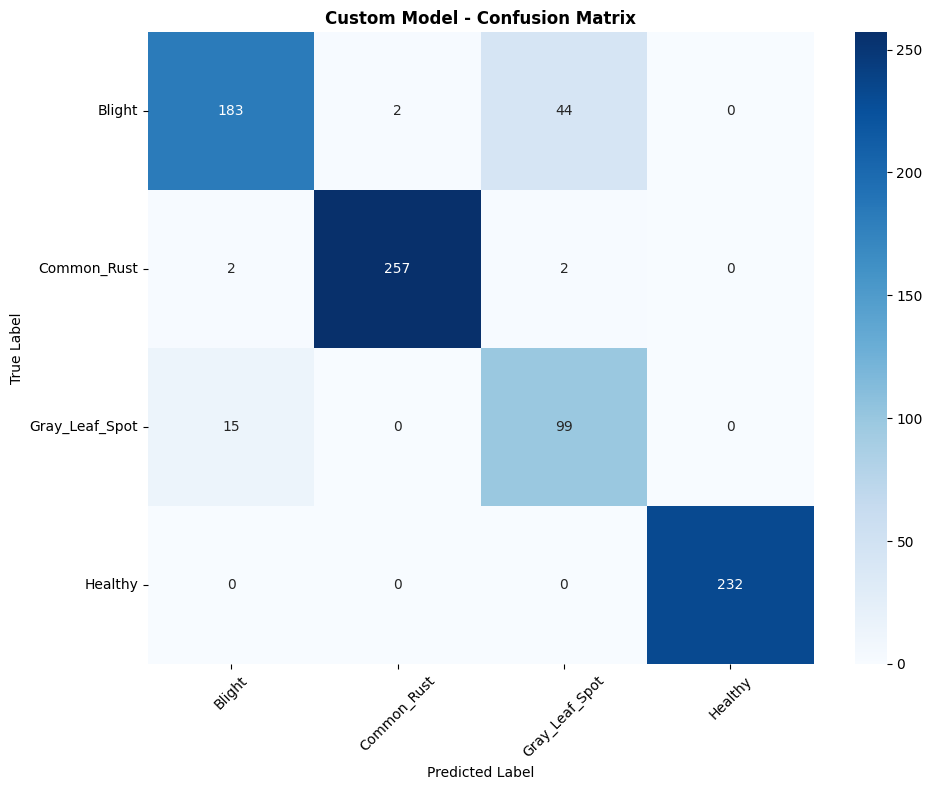


📈 Detailed Classification Report:
                precision    recall  f1-score   support

        Blight       0.92      0.80      0.85       229
   Common_Rust       0.99      0.98      0.99       261
Gray_Leaf_Spot       0.68      0.87      0.76       114
       Healthy       1.00      1.00      1.00       232

      accuracy                           0.92       836
     macro avg       0.90      0.91      0.90       836
  weighted avg       0.93      0.92      0.92       836



In [9]:
# ========== CELL 9: Custom Model Evaluation ==========
def evaluate_custom_model(model, val_generator):
    """Evaluate the custom model with detailed metrics"""

    print("🧪 Evaluating Custom CNN Model")
    print("="*50)

    # Basic evaluation
    evaluation = model.evaluate(val_generator, verbose=1)
    metrics = ['loss', 'accuracy', 'precision', 'recall']

    print("\n📊 Evaluation Results:")
    print("="*30)
    for metric, value in zip(metrics, evaluation):
        print(f"{metric.capitalize()}: {value:.4f}")

    # Predictions
    val_generator.reset()
    predictions = model.predict(val_generator, verbose=0)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = val_generator.classes

    # Class labels
    class_labels = list(val_generator.class_indices.keys())

    # Confusion Matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(true_classes, predicted_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Custom Model - Confusion Matrix', fontweight='bold')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # Classification Report
    print("\n📈 Detailed Classification Report:")
    print("="*40)
    report = classification_report(true_classes, predicted_classes,
                                   target_names=class_labels)
    print(report)

    return evaluation

# Evaluate the custom model
custom_model_results = evaluate_custom_model(model, val_generator)

In [ ]:
# ========== CELL 10: Custom Model Visualization ==========
# Plot training history for custom model
def plot_custom_model_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    ax1.set_title('Custom Model - Accuracy', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Loss
    ax2.plot(history.history['loss'], label='Training Loss', linewidth=2)
    ax2.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    ax2.set_title('Custom Model - Loss', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_custom_model_history(history)

In [11]:
# ========== CELL 11: Model Comparison & Summary ==========
print("🔍 CUSTOM MODEL ARCHITECTURE ANALYSIS")
print("="*50)
print("Model Type: Custom CNN (Built from Scratch)")
print("Input Shape: 384x384x3")
print(f"Number of Layers: {len(model.layers)}")
print(f"Total Parameters: {model.count_params():,}")
print(f"Number of Classes: {len(train_generator.class_indices)}")

# Get final metrics
final_accuracy = history.history['val_accuracy'][-1]
final_loss = history.history['val_loss'][-1]

print(f"\n📊 Final Training Results:")
print(f"Final Validation Accuracy: {final_accuracy:.4f}")
print(f"Final Validation Loss: {final_loss:.4f}")

print("\n✅ Model Advantages:")
print("- No dependency on pre-trained models")
print("- Complete control over architecture")
print("- Better understanding of model behavior")
print("- Optimized specifically for corn leaf diseases")

# Save model summary
with open('/content/custom_model_summary.txt', 'w') as f:
    def print_to_file(x):
        f.write(x + '\n')
    model.summary(print_fn=print_to_file)

print("✅ Custom model analysis completed!")

🔍 CUSTOM MODEL ARCHITECTURE ANALYSIS
Model Type: Custom CNN (Built from Scratch)
Input Shape: 384x384x3
Number of Layers: 34
Total Parameters: 40,273,444
Number of Classes: 4

📊 Final Training Results:
Final Validation Accuracy: 0.9014
Final Validation Loss: 0.5272

✅ Model Advantages:
- No dependency on pre-trained models
- Complete control over architecture
- Better understanding of model behavior
- Optimized specifically for corn leaf diseases


✅ Custom model analysis completed!


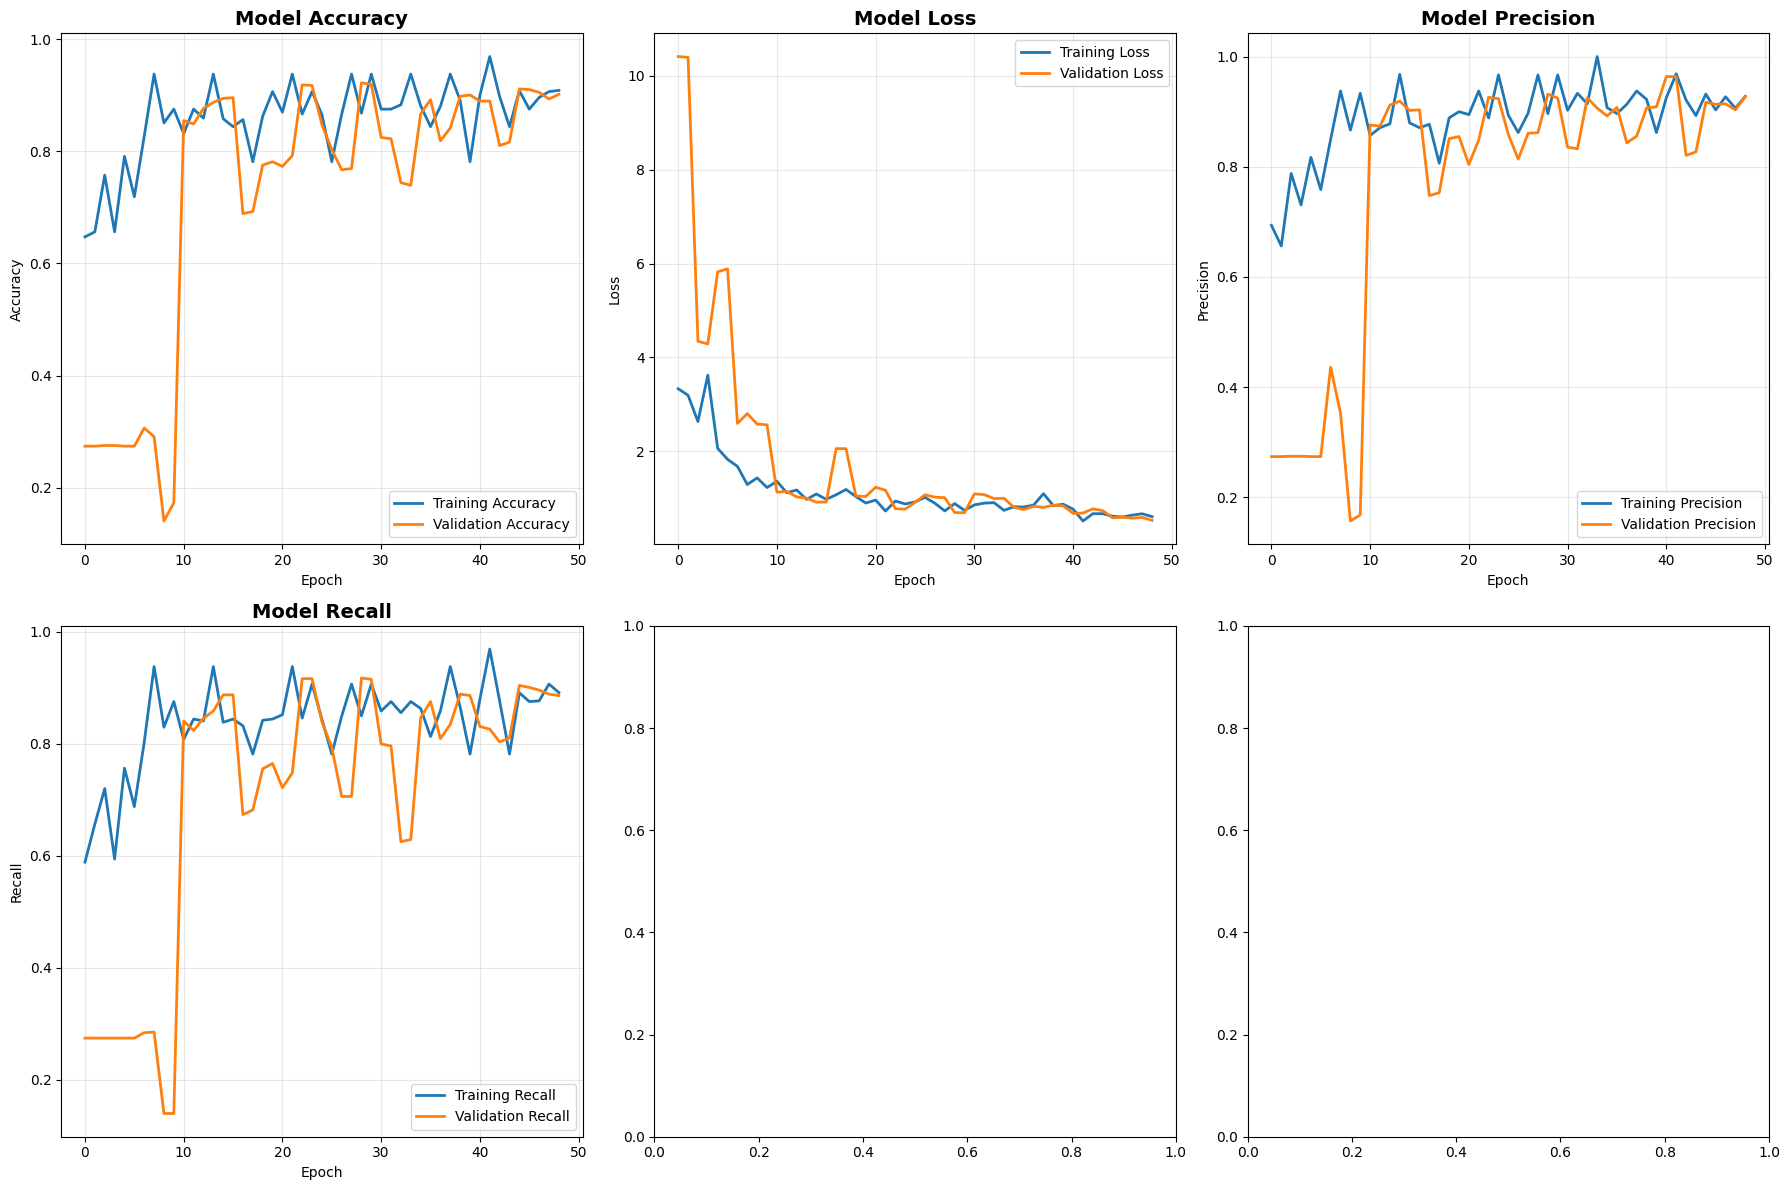

In [12]:
# ========== CELL 9: Enhanced Training Visualization ==========
def plot_training_history(history):
    """Enhanced training history visualization"""

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # Accuracy
    axes[0,0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    axes[0,0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    axes[0,0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
    axes[0,0].set_xlabel('Epoch')
    axes[0,0].set_ylabel('Accuracy')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)

    # Loss
    axes[0,1].plot(history.history['loss'], label='Training Loss', linewidth=2)
    axes[0,1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    axes[0,1].set_title('Model Loss', fontsize=14, fontweight='bold')
    axes[0,1].set_xlabel('Epoch')
    axes[0,1].set_ylabel('Loss')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)

    # Precision
    axes[0,2].plot(history.history['precision'], label='Training Precision', linewidth=2)
    axes[0,2].plot(history.history['val_precision'], label='Validation Precision', linewidth=2)
    axes[0,2].set_title('Model Precision', fontsize=14, fontweight='bold')
    axes[0,2].set_xlabel('Epoch')
    axes[0,2].set_ylabel('Precision')
    axes[0,2].legend()
    axes[0,2].grid(True, alpha=0.3)

    # Recall
    axes[1,0].plot(history.history['recall'], label='Training Recall', linewidth=2)
    axes[1,0].plot(history.history['val_recall'], label='Validation Recall', linewidth=2)
    axes[1,0].set_title('Model Recall', fontsize=14, fontweight='bold')
    axes[1,0].set_xlabel('Epoch')
    axes[1,0].set_ylabel('Recall')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)

    # Learning Rate (if available)
    if 'lr' in history.history:
        axes[1,1].plot(history.history['lr'], label='Learning Rate', linewidth=2, color='red')
        axes[1,1].set_title('Learning Rate', fontsize=14, fontweight='bold')
        axes[1,1].set_xlabel('Epoch')
        axes[1,1].set_ylabel('LR')
        axes[1,1].set_yscale('log')
        axes[1,1].grid(True, alpha=0.3)

    # AUC (if available)
    if 'auc' in history.history:
        axes[1,2].plot(history.history['auc'], label='Training AUC', linewidth=2)
        axes[1,2].plot(history.history['val_auc'], label='Validation AUC', linewidth=2)
        axes[1,2].set_title('Model AUC', fontsize=14, fontweight='bold')
        axes[1,2].set_xlabel('Epoch')
        axes[1,2].set_ylabel('AUC')
        axes[1,2].legend()
        axes[1,2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history(history)

In [13]:
model.save("corn_leaf.keras")

In [14]:
files.download("corn_leaf.keras")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>